<a href="https://colab.research.google.com/github/FigoStevhen/Klasifikasi-Mangga-Arumanis/blob/main/Kelompok_7_Klasifikasi_Mangga_CNN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow opencv-python matplotlib

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random
from google.colab import drive
import shutil

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_dir = '/content/drive/MyDrive/Dataset_Mangga'
base_dir = '/content/drive/MyDrive/structured_dataset'

In [ ]:
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(base_dir)

classes = ['Sangat Matang', 'Matang', 'Muda']
class_map = {'Sangat Matang' : 'sangat_matang', 'Matang' : 'matang', 'Muda': 'muda'}

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(train_dir)
os.makedirs(validation_dir)

for original_class in classes:
    mapped_class = class_map[original_class]
    os.makedirs(os.path.join(train_dir, mapped_class))
    os.makedirs(os.path.join(validation_dir, mapped_class))

split_ratio = 0.8
for original_class in classes:
    mapped_class = class_map[original_class]
    class_source_dir = os.path.join(source_dir, original_class)

    if not os.path.isdir(class_source_dir):
        print(f"Peringatan: Direktori sumber tidak ditemukan untuk kelas {original_class}: {class_source_dir}")
        continue

    files = os.listdir(class_source_dir)
    random.shuffle(files)

    split_point = int(len(files) * split_ratio)
    train_files = files[:split_point]
    validation_files = files[split_point:]

    for f in train_files:
        src = os.path.join(class_source_dir, f)
        dst = os.path.join(train_dir, mapped_class, f)
        shutil.copyfile(src, dst)

    for f in validation_files:
        src = os.path.join(class_source_dir, f)
        dst = os.path.join(validation_dir, mapped_class, f)
        shutil.copyfile(src, dst)

print("Struktur dataset telah berhasil dibuat.")

Struktur dataset telah berhasil dibuat.


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir_processed = '/content/drive/MyDrive/structured_dataset/train'
validation_dir_processed = '/content/drive/MyDrive/structured_dataset/validation'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir_processed,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir_processed,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Kelas yang ditemukan:", class_names)

Found 668 files belonging to 3 classes.
Found 169 files belonging to 3 classes.
Kelas yang ditemukan: ['matang', 'muda', 'sangat_matang']


In [ ]:
!pip install -q keras-cv

import tensorflow as tf
import keras_cv

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 53.8 MB/s eta 0:00:00


In [ ]:
def apply_augmentations(images, labels):
    samples = {"images": images, "labels": labels}
    samples = mix_up(samples, training=True)
    images_augmented = data_augmentation(samples["images"], training=True)
    return images_augmented, samples["labels"]

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(apply_augmentations, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
base_model = EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

inputs = Input(shape=IMG_SIZE + (3,))

x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        40,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,090,662 (15.60 MB)

 Trainable params: 41,091 (160.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
import numpy as np
from sklearn.utils import class_weight

train_labels = np.concatenate([y for x, y in train_ds], axis=0)
train_labels_int = np.argmax(train_labels, axis=1)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels_int),
    y=train_labels_int
)
class_weights_dict = dict(enumerate(class_weights))

print("Bobot Kelas yang Dihitung:", class_weights_dict)

Bobot Kelas yang Dihitung: {0: np.float64(0.9940476190476191), 1: np.float64(0.8942436412315931), 2: np.float64(1.1418803418803418)}


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


base_model.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping_stage1 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_stage1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-5
)

print("--- Memulai Pelatihan Tahap 1: Feature Extraction ---")
history_feature_extraction = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    class_weight=class_weights_dict,
    callbacks=[early_stopping_stage1, reduce_lr_stage1]
)

--- Memulai Pelatihan Tahap 1: Feature Extraction ---
Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 940ms/step - accuracy: 0.8337 - loss: 0.4766 - val_accuracy: 0.8817 - val_loss: 0.2824 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.8410 - loss: 0.4401 - val_accuracy: 0.8757 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8628 - loss: 0.4379 - val_accuracy: 0.8698 - val_loss: 0.2743 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8501 - loss: 0.4403 - val_accuracy: 0.8757 - val_loss: 0.2824 - learning_rate: 0.0010
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8762 - loss: 0.4267 - val_accuracy: 0.8698 - val_loss: 0.2864 - learning_rate: 0.0010
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8715 - loss: 0.4537 - val_accuracy: 0.8639 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 50

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "finetune_model_terbaik.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)


print("--- Memulai Pelatihan Tahap 2: Fine-Tuning ---")
history_fine_tuning = model.fit(
    train_ds,
    epochs=50,
    initial_epoch=history_feature_extraction.epoch[-1],
    validation_data=val_ds,
    class_weight=class_weights_dict,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)

print("✅ Pelatihan Tahap 2 Selesai.")


--- Memulai Pelatihan Tahap 2: Fine-Tuning ---
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.7169 - loss: 0.7291
Epoch 15: val_accuracy improved from -inf to 0.88757, saving model to finetune_model_terbaik.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7173 - loss: 0.7292 - val_accuracy: 0.8876 - val_loss: 0.2582 - learning_rate: 1.0000e-05
Epoch 16/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7402 - loss: 0.6623
Epoch 16: val_accuracy did not improve from 0.88757
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.7403 - loss: 0.6631 - val_accuracy: 0.8876 - val_loss: 0.2773 - learning_rate: 1.0000e-05
Epoch 17/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7348 - loss: 0.6243
Epoch 17: val_accuracy did not improve from 0.88757
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7345 - loss: 0.6249 - val_accuracy: 0.8817 - val_loss: 0.2928 - learning_rate: 1.0000e-05
Epoch 18/50
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accur

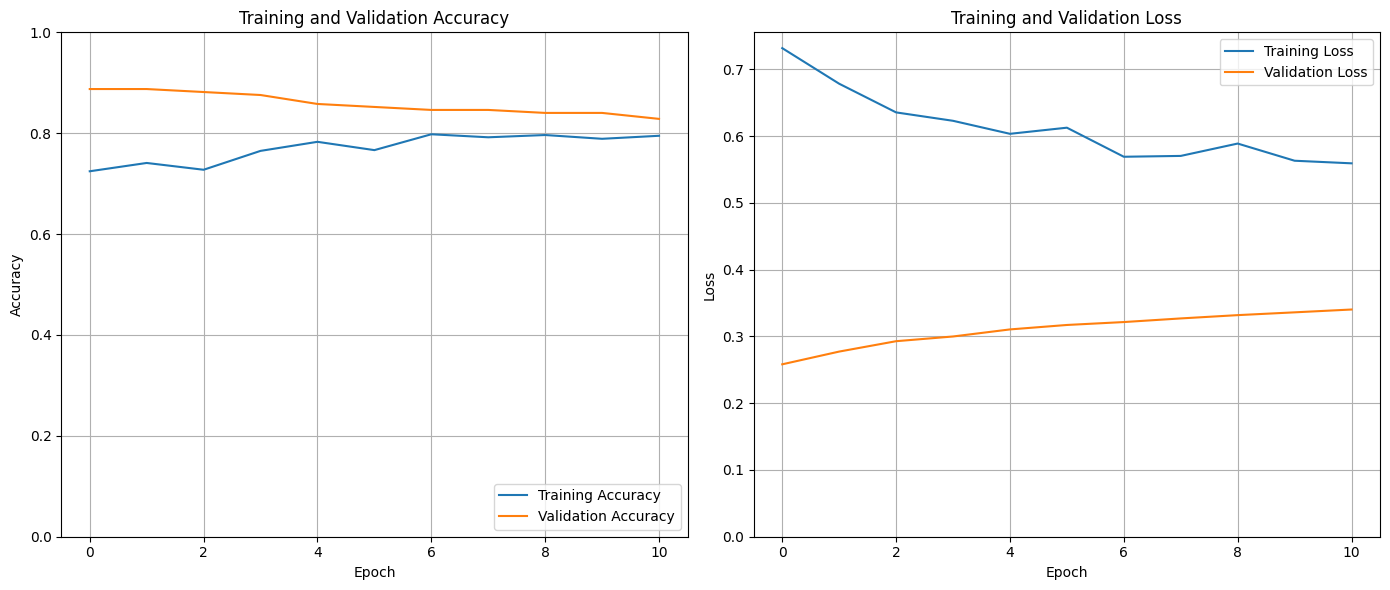

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.ylim([0, 1])
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.ylim(bottom=0)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history_fine_tuning)

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


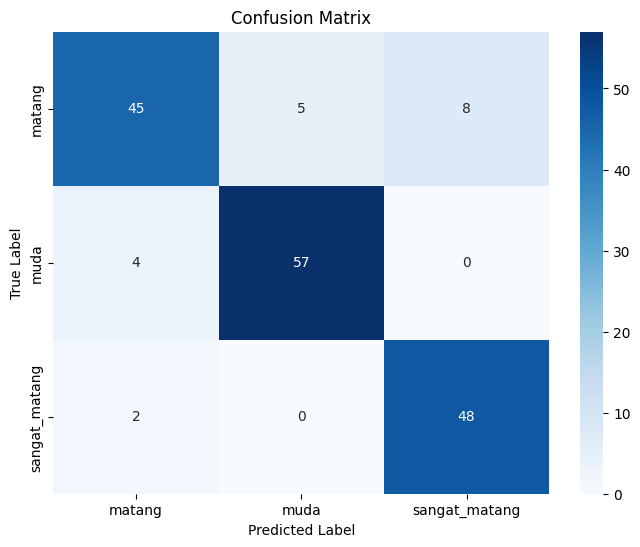

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([np.argmax(label.numpy(), axis=1) for _, label in val_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
class_names_list = class_names

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list, yticklabels=class_names_list)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/model_lite_V6.keras")

# **Hasil Pengujian Model**

✅ Model berhasil dimuat.
Found 668 files belonging to 3 classes.
📂 Daftar kelas: ['matang', 'muda', 'sangat_matang']


Saving WhatsApp Image 2025-06-28 at 19.25.53 (1).jpeg to WhatsApp Image 2025-06-28 at 19.25.53 (1).jpeg
📷 Gambar diupload: WhatsApp Image 2025-06-28 at 19.25.53 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

📊 Probabilitas Kelas:
  matang: 0.2110
  muda: 0.0045
  sangat_matang: 0.7844

✅ Hasil Prediksi: sangat_matang


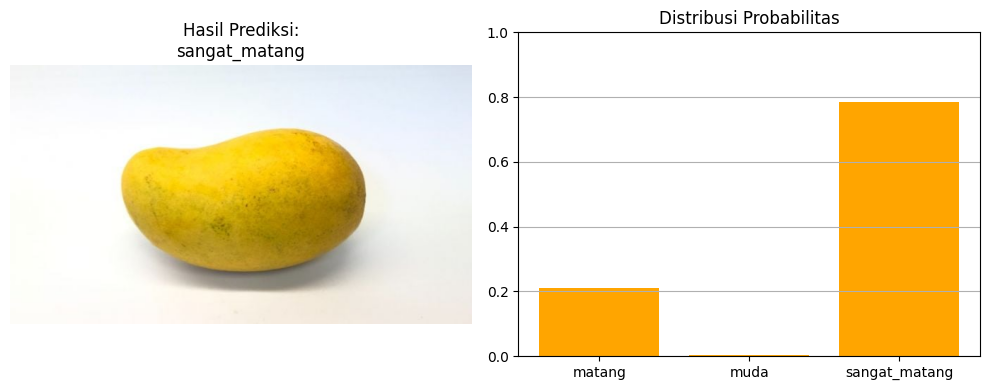

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive, files

model_path = '/content/drive/MyDrive/model_lite_V6.keras'
model = tf.keras.models.load_model(model_path)
print("✅ Model berhasil dimuat.")

IMG_SIZE = (224, 224)
train_dir = '/content/drive/MyDrive/structured_dataset/train'

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    shuffle=False,
    batch_size=1
)
class_names = train_ds.class_names
print("📂 Daftar kelas:", class_names)

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
print("📷 Gambar diupload:", img_path)

def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return tf.expand_dims(img, axis=0)

img_tensor = preprocess_image(img_path)
pred = model.predict(img_tensor)
pred_idx = tf.argmax(pred, axis=1).numpy()[0]
pred_label = class_names[pred_idx]

print("\n📊 Probabilitas Kelas:")
for i, p in enumerate(pred[0]):
    print(f"  {class_names[i]}: {p:.4f}")
print(f"\n✅ Hasil Prediksi: {pred_label}")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
img = load_img(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Hasil Prediksi:\n{pred_label}")

plt.subplot(1, 2, 2)
plt.bar(class_names, pred[0], color='orange')
plt.ylim(0, 1)
plt.title("Distribusi Probabilitas")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 280, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 280, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 280, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 7, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,377,960 (89.18 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 1,050,118 (4.01 MB)